Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 4985263.45it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 132304.44it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:48<00:00, 34332.89it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 3902197.62it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



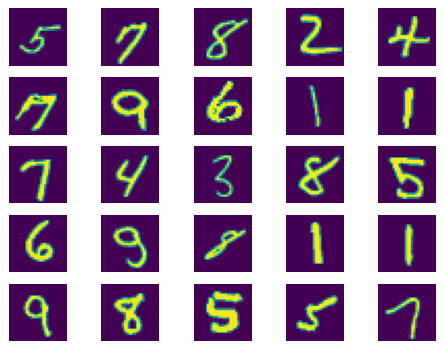

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

mnist = MNIST(root='.', download=True)
images = np.stack([data[0] for data in mnist]).astype(np.float32)
images = images / 128 - 1    # normalize between -1 and 1
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[np.random.choice(len(images))])
    plt.axis('off')
plt.show()

### Generator and Discriminator
In this part, we implement a generator and discriminator model.
* The **generator** takes a randomly sampled noise $z$ as input and outputs an image with the same size as the dataset
* The **discriminator** takes an image as input and performs a binary classification

In this case, both the generator and discriminator should be convolutional neural networks (CNNs).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        ####################################################################################
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 1)
        ####################################################################################

    def forward(self, x):
        ####################################################################################
        # print("Discriminator")
        # print(x.shape)
        x = x.view(-1, 1, 28, 28)
        # print(x.shape)
        ####################################################################################
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        # print(x.shape)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        # print(x.shape)
        x = x.view(-1, 128 * 7 * 7)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        # print(x.shape)
        x = F.softmax(x)
        # print("2: ", x.shape)
        x = self.fc2(x)
        # print("3: ", x.shape)
        return x
        ####################################################################################

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        ####################################################################################
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        ####################################################################################

    def forward(self, x):
        ####################################################################################
        x = self.fc1(x)
        # print(x.shape)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        # print(x.shape)
        x = x.view(-1, 128, 7, 7)
        # print(x.shape)
        x = F.leaky_relu(self.deconv1(x), negative_slope=0.2)
        # print(x.shape)
        x = F.sigmoid(self.deconv2(x))
        # print("1: ", x.shape)
        # x = x.view(-1, 128, 28, 28)
        return x
        ####################################################################################

gen = Generator()
disc = Discriminator()
if torch.cuda.is_available:
    gen = gen.cuda()
    disc = disc.cuda()

### Generate image samples from generator

During the training and inference, the generator needs to generate batch of images from random noise.

In [3]:
def generate_samples(model, num_samples):
    ####################################################################################
    with torch.no_grad():
        noise = torch.randn(num_samples, 1).cuda()
        samples = model(noise).squeeze()
    return samples
    ####################################################################################

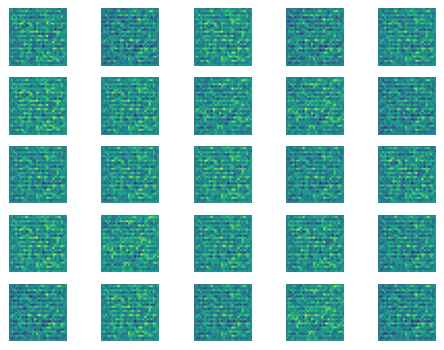

In [4]:
gen.eval()
samples = generate_samples(gen, 25).detach().cpu().numpy()
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()

### GAN training algorithm
In this part, we implement the GAN training algorithm, which involves alternating the training of discriminator and generator.

In [5]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

import torch.optim as optim

def train_gan(gen, disc, images, num_epochs, batch_size):
    from tqdm.autonotebook import tqdm
    from torch.utils.data import DataLoader

    losses_gen = []
    losses_disc = []

    gen.train()
    disc.train()
    loader = DataLoader(images, batch_size=batch_size, shuffle=True)

    ####################################################################################
    optimizer_gen = optim.Adam(disc.parameters(), 0.002)
    optimizer_disc = optim.Adam(gen.parameters(), 0.002)

    pbar = tqdm(range(num_epochs))
    for e in pbar:
        for i, data_real in enumerate(loader):
            if torch.cuda.is_available:
                data_real = data_real.cuda()

            disc.train()
            disc.requires_grad_(True)

            disc.zero_grad()
            inputs_disc = data_real
            labels_disc = torch.ones(data_real.size(0), 1)
            if torch.cuda.is_available:
                inputs_disc = inputs_disc.cuda()
                labels_disc = labels_disc.cuda()

            inputs_disc_fake = generate_samples(gen, data_real.size(0))
            labels_disc_fake = torch.zeros(data_real.size(0), 1)*0.9
            if torch.cuda.is_available:
                inputs_disc_fake = inputs_disc_fake.cuda()
                labels_disc_fake = labels_disc_fake.cuda()

            loss_disc_real = disc(inputs_disc)
            loss_disc_real = nn.BCEWithLogitsLoss()(loss_disc_real, labels_disc)

            loss_disc_fake = disc(inputs_disc_fake)
            loss_disc_fake = nn.BCEWithLogitsLoss()(loss_disc_fake, labels_disc_fake)

            loss_disc = (loss_disc_fake + loss_disc_real) * 0.5
            loss_disc.backward()
            optimizer_disc.step()
            losses_disc.append(loss_disc.item())

            disc.eval()
            disc.requires_grad_(False)

            gen.zero_grad()

            inputs_gen = generate_samples(gen, data_real.size(0))
            labels_gen = torch.ones(data_real.size(0), 1)
            if torch.cuda.is_available:
                inputs_gen = inputs_gen.cuda()
                labels_gen = labels_gen.cuda()

            loss_gen = disc(inputs_gen)
            loss_gen = nn.BCEWithLogitsLoss()(loss_gen, labels_gen)
            # loss_gen.backward()

            optimizer_gen.step()
            losses_gen.append(loss_gen.item())
    ####################################################################################

            pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1])
    return losses_gen, losses_disc

In [6]:
num_epochs = 10
batch_size = 128
losses_gen, losses_disc = train_gan(gen, disc, images, num_epochs=num_epochs, batch_size=batch_size)

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-2-1439642fbe34>:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


### Observations and Analysis

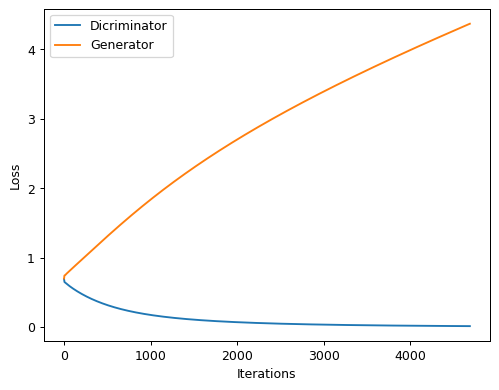

In [7]:
plt.figure(dpi=90)
plt.plot(losses_disc, label='Dicriminator')
plt.plot(losses_gen, label='Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

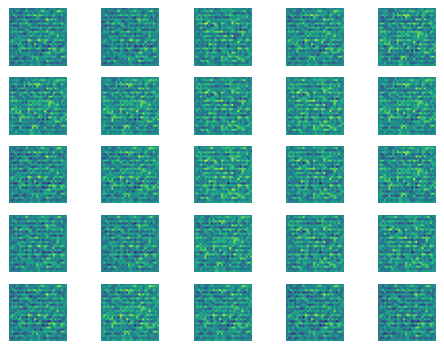

In [8]:
gen.eval()
samples = generate_samples(gen, 25).detach().cpu().numpy()
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()